# SEIR model

Будем рассматривать модель Susceptible-Exposed-Infected-Recovered для эпидемиологических моделей.
Зададим её как
$
\begin{cases}
\dot{S} = -\alpha S I \\
\dot{E} = \alpha S I - \gamma E \\
\dot I = \gamma E - \beta I \\
\dot R = \beta I
\end{cases}
$,

где скорости переходов $\alpha$, $\beta$ и $\gamma$ соответствуют диаграмме перехода
$S \rightarrow_{\alpha I} E \rightarrow_{\gamma} I \rightarrow_{\beta} R$.

Так же дополнительно определим $N = S + E + I + R = 1$

С помощью символьных вычислений попробуем решить наше систему уравнений при малых $t$, а именно:
* $S \approx 1$

Будем использовать *метод характеристических многочленов*.

In [1]:
import sympy as sp

a, b, g, l = sp.symbols(r"\alpha, \beta, \gamma, \lambda")
M_t0 = sp.Matrix([[-l, 0, -a, 0], [0, -g - l, a, 0], [0, g, -b - l, 0], [0, 0, b, -l]])
M_t0

Matrix([
[-\lambda,                 0,          -\alpha,        0],
[       0, -\gamma - \lambda,           \alpha,        0],
[       0,            \gamma, -\beta - \lambda,        0],
[       0,                 0,            \beta, -\lambda]])

Получили хакартеристический многочлен:

In [2]:
char_poly =  M_t0.det()
sp.factor(char_poly)

-\lambda**2*(\alpha*\gamma - \beta*\gamma - \beta*\lambda - \gamma*\lambda - \lambda**2)

Его корни:

In [3]:
sp.roots(char_poly, l)

{-\beta/2 - \gamma/2 - sqrt(4*\alpha*\gamma + \beta**2 - 2*\beta*\gamma + \gamma**2)/2: 1,
 -\beta/2 - \gamma/2 + sqrt(4*\alpha*\gamma + \beta**2 - 2*\beta*\gamma + \gamma**2)/2: 1,
 0: 2}

Видим, соответственно, 2 корня, возникающих из выражения по скобками, и $0$ второй степени, который даёт нам $\lambda^2$

Посмотрим на первые 2 корня в красивом виде:


In [10]:
sp.Eq(sp.Symbol(r"\lambda_1"), sp.factor(list(sp.roots(char_poly, l))[0]))

Eq(\lambda_1, -(\beta + \gamma + sqrt(4*\alpha*\gamma + \beta**2 - 2*\beta*\gamma + \gamma**2))/2)

In [11]:
sp.Eq(sp.Symbol(r"\lambda_2"), sp.factor(list(sp.roots(char_poly, l))[1]))

Eq(\lambda_2, -(\beta + \gamma - sqrt(4*\alpha*\gamma + \beta**2 - 2*\beta*\gamma + \gamma**2))/2)

Заметим следующие моменты:
* $\lambda_1$ постоянно убывает
* при равных $\beta$ и $\gamma$ эволюцию $\lambda$ будет определять только $\alpha$, что нам в численных экспериментах пригодится.

## 1. Найдём Basic Reproductive Number $R_0$ для нашей модели

Теперь посмотрим на наши значения $\lambda$ и вспомним, что они - показатели экспонент в общем решениии системы.
А значит при:
* $\lambda < 0$ экспоненты — убывающие функции
* $\lambda > 0$ экспоненты — возрастающие

В нашем случае, $\lambda_1 <= 0$ всегда. Таким образом, мы можем получить $R_0$ для **SEIR**,
решив $\lambda_2 = 0$.

In [14]:
eq = sp.Eq(0, sp.factor(list(sp.roots(char_poly, l))[1]))
eq

Eq(0, -(\beta + \gamma - sqrt(4*\alpha*\gamma + \beta**2 - 2*\beta*\gamma + \gamma**2))/2)

In [15]:
sp.solve(eq)

[{\alpha: \beta}, {\gamma: 0}]

То есть, релевантным $R_0$ является $\frac{\alpha}{\beta}$.

## 2. Среднее время между заражением человека и моментом, когда он заразил кого-то другого.

Здесь заметим следующее:

время до первого заражения другого человека после собственного заражения $=$ время пребывания в $E$ $+$ время до заражения другого человека во время пребывания в $I$.

$T = T_E + \widetilde{T_I}$

Оценим по слагаемым:

### 2.1 Оценка $T_E$

Если не учитывать динамику заполения во втором уравнении в **SEIR**, то очевидно,
что $E$ распределено экспонециально с параметром $\gamma$.
Таким образом, среднее время пребывания в $E$ составляет $\frac{1}{\gamma}$.


### 2.2 Оценка $\widetilde{T_I}$




## 3. Показатель экспоненциального роста эпидемии на ранних стадиях

Собственно, найденные значения $\lambda$ как раз описывают комбинацию экспоненциального роста и падения.

Более конкретно, решение каждого уравнения системы выглядит как $\dot x = C_1 e^{\lambda_1} + C_2 e^{\lambda 2} + C_3$

## 4. Численное моделлирование

In [42]:
import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
%matplotlib inline

def seir(t, vec, alpha, beta, gamma):
    s, e, i, r = vec
    return [
        -alpha * s * i,
        alpha * s * i - gamma * e,
        gamma * e - beta * i,
        beta * i
    ]

def view_seir_model(t_span, alpha, beta=3, gamma=3):
    vec_0 = [0.9999, 0.0001, 0., 0.]
    sol = solve_ivp(seir, t_span, vec_0, args=[alpha, beta, gamma], dense_output=True)

    t = np.linspace(*t_span, num=100)
    res = sol.sol(t)

    plt.plot(t, res.T)
    plt.xlabel('t')
    plt.legend(['S', 'E', 'I', 'R'], shadow=True)
    plt.title(f"SEIR system with {alpha=}, {beta=}, {gamma=}")

    print(res.shape)
    print(f"Solution at the end point t={t_span[-1]}: ")
    print(f"S={np.round(res[0][-1], 3)}")
    print(f"E={np.round(res[1][-1], 3)}")
    print(f"I={np.round(res[2][-1], 3)}")
    print(f"R={np.round(res[3][-1], 3)}")

### $\alpha$ = 1; $R_0 < 1$

(4, 100)
Solution at the end point t=10: 
S=1.0
E=0.0
I=-0.0
R=0.0


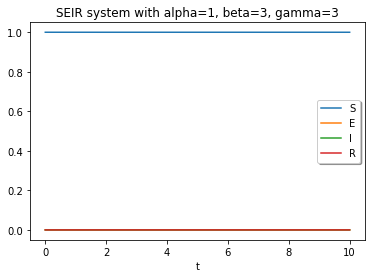

In [43]:
view_seir_model(alpha=1, t_span=[0, 10])

### $\alpha$ = 3; $R_0 = 1$

(4, 100)
Solution at the end point t=1000: 
S=0.986
E=0.0
I=-0.0
R=0.014


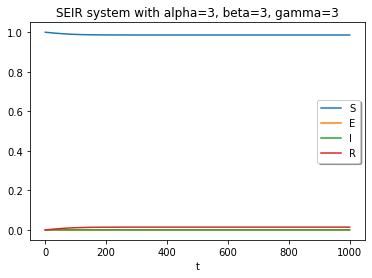

In [44]:
view_seir_model(alpha=3, t_span=[0, 1000])

### $\alpha$ = 4; $R_0 > 1$

(4, 100)
Solution at the end point t=30: 
S=0.546
E=0.0
I=0.0
R=0.454


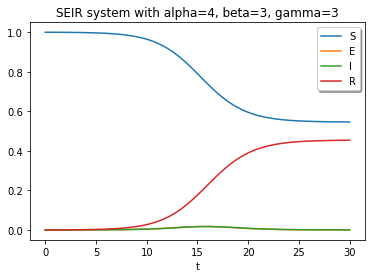

In [45]:
view_seir_model(alpha=4, t_span=[0, 30])

### $\alpha$ = 6; $R_0 > 1$

(4, 100)
Solution at the end point t=20: 
S=0.203
E=0.0
I=0.0
R=0.797


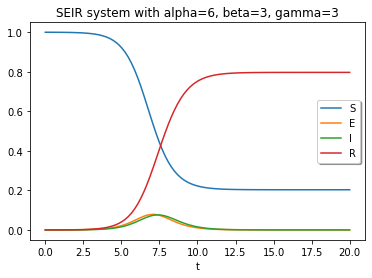

In [46]:
view_seir_model(alpha=6, t_span=[0, 20])

### $\alpha$ = 10; $R_0 \gg 1$

(4, 100)
Solution at the end point t=10: 
S=0.041
E=0.0
I=0.0
R=0.959


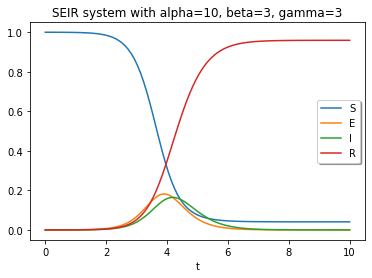

In [47]:
view_seir_model(alpha=10, t_span=[0, 10])

Как мы видим, $R_0$ действительно характеризует динамику распространения модели.
* $R_0 < 1$ - эпидемия быстро угасает
* $R_0 = 1$ - эпидения не поражает значительную долю населения
* $R_0 > 1$ - эпидемия поражает значительную долю населения и тем больше, чем больше $R_0$

В начале эпидемии число заражённых действительно растёт экспоненциально, а величины $S$ и $I$ имеют вид, явно схожий с сигмоидой.